# Datenerzeugung: Power-Spektrum

Klasse zum Laden und Plotten der simulierten und realen Daten\
Eigene Implementierung der diskreten Fourier-Transformation (DFT) und anschließende Berechnung des Single-Sided-Power-Spektrums\
basierend auf https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.02-Discrete-Fourier-Transform.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class spektral:

    def __init__(self,path,time_or_spec,f_A=None,dB=False,calc_dB=False) -> None:
        '''Übergabe eines Pfades/Dateinamen der dann geladen wird.
        Angabe notwendig, ob es sich um Time Series oder Spektrum handelt.
        Falls es eine Zeitreihe ist, kann eine Abtastfrequenz übergeben
        werden. In diesem Fall wird das Spektrum zusätzlich selbst 
        berechnet. Falls time_or_spec==both ist path ein Tupel mit
        (time, spec). Falls time_or_spec='time', f_A nicht None und
        calc_dB=True wird das Spektrum in dB berechnet.'''
        self.time_or_spec = time_or_spec
        self.dB = dB
        # Transponiere, um x-Achse an Index 0 zu haben
        if time_or_spec == 'time':
            self.time = np.loadtxt(path, usecols=(0,1)).T
        if time_or_spec == 'spec':
            self.spec = np.loadtxt(path, usecols=(0,1)).T
        if time_or_spec == 'both':
            self.time = np.loadtxt(path[0], usecols=(0,1)).T
            self.spec = np.loadtxt(path[1], usecols=(0,1)).T            
        if time_or_spec == 'time' and f_A is not None:
            self.time_or_spec = 'both'
            if calc_dB == False:
                self.spec = self.spectrum(self.time[1],f_A)
            elif calc_dB == True and dB == True:
                ayuda = self.spectrum(self.time[1],f_A)
                ayuda[1][ayuda[1] == 0.0] = np.nan
                # Umrechnung der Leistung in Dezibel mit Referenzwert 1
                helper_dB = 10.0*np.log10(ayuda[1])
                self.spec = [ayuda[0],helper_dB]

    def plot(self,ax,label=None,which_plot=None):
        '''Die Funktion plotted Daten in subplot ax.
        time_or_spec gibt an, ob timeseries oder Spekrum geplotted werden soll.
        Falls time_or_spec==both kann mit which_plot gesagt werden, was geplotted 
        werden soll.'''

        if self.time_or_spec == 'time' or which_plot == 'time':
            ax.plot(self.time[0],self.time[1],label=label)
            ax.set_xlabel('Zeit in Sekunden')
            ax.set_ylabel('Auslenkung in V')

        if self.time_or_spec == 'spec' or which_plot == 'spec':
            ax.plot(self.spec[0],self.spec[1],label=label)
            ax.set_xlabel('Frequenz in Hz')
            if self.dB == False:
                ax.set_ylabel(r'Leistung in V$^2$')
            if self.dB == True:
                ax.set_ylabel(r'Leistung in dB')

    def plot_both(self,title=None,x1lim=None,x2lim=None):
        '''Bei der Zeitreihe und Frequenz kann der Bereich der x-Achse angegeben werden.'''
        fig, (ax1, ax2) = plt.subplots(2,1,figsize=(6,7))
        ax1.plot(self.time[0],self.time[1])
        ax1.set_xlabel('Zeit in Sekunden')
        ax1.set_ylabel('Auslenkung in V')
        if x1lim is not None:
            ax1.set_xlim(x1lim)
        if self.dB == False:
            ax2.plot(self.spec[0],self.spec[1])
            ax2.set_ylabel(r'Leistung in V$^2$')
        if self.dB == True:
            ax2.plot(self.spec[0],self.spec[1])
            ax2.set_ylabel(r'Leistung in dB')
        ax2.set_xlabel('Frequenz in Hz')
        if x2lim is not None:
            ax2.set_xlim(x2lim)
        if title is not None:
            ax1.set_title(title)

    def dft(self,x,f_A):
        N = len(x)
        n = np.arange(N)

        freq = n*f_A/N

        k = n.reshape((N, 1))
        e = np.exp(-2j * np.pi * k * n / N)
        S = abs(np.dot(e, x))  # Nehme den Betrag der komplexen Zahlen
        
        return freq, S

    def spectrum(self,x,f_A):
        '''Berechnung des Single-Sided-Power-Spektrums (Betragsquadrat des Amplitudenspektrums).'''
        freq, S = self.dft(x,f_A)

        N = len(freq)
        N_half = int(N/2)
        P = np.zeros(N)
        P[0] = S[0]**2/N/N
        for i in range(1,N_half):
            P[i] = 2*(S[i]**2)/N/N
        return [freq, P]

Verifikation, dass die eigene Implementierung der DFT funktioniert. Dafür werden die Spektren zur Datensatzlänge rekonstruiert:

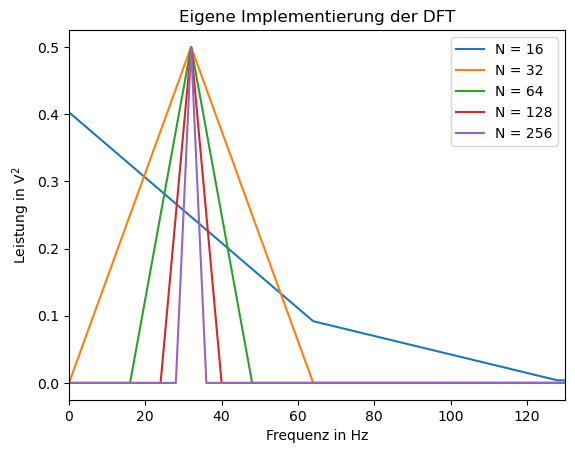

In [9]:
N = [16,32,64,128,256]

fig, ax = plt.subplots()

for i in N:
    data = spektral('2/2b/Len_'+str(i)+'.dat','time')
    freq, P = data.spectrum(data.time[1],1024.0)
    ax.plot(freq,P,label='N = '+str(i))
    ax.plot()

ax.set_xlabel('Frequenz in Hz')
ax.set_ylabel(r'Leistung in V$^2$')
plt.title('Eigene Implementierung der DFT')
plt.legend()
plt.xlim(0,130)
plt.savefig('figures/datensatzlänge_dft.pdf')

Einfluss der Datensatzlänge auf Spektrum der FFT:

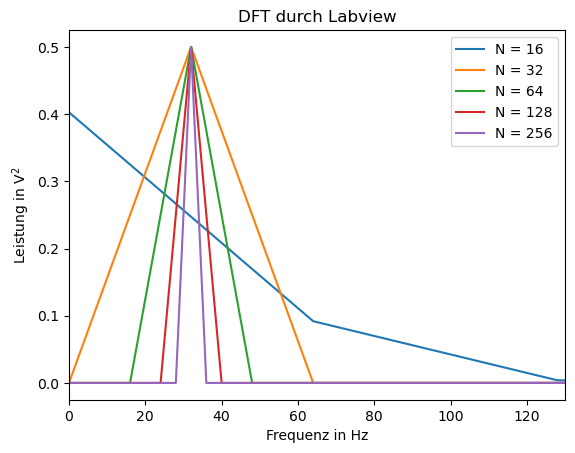

In [10]:
N = [16,32,64,128,256]

fig, ax = plt.subplots()

for i in N:
    data = spektral('2/2b/len'+str(i)+'.aps','spec')
    data.plot(ax,label='N = '+str(i))

plt.title('DFT durch Labview')
plt.legend()
plt.xlim(0,130)
plt.savefig('figures/datensatzlänge.pdf')

DC-Anteil im Spektrum:

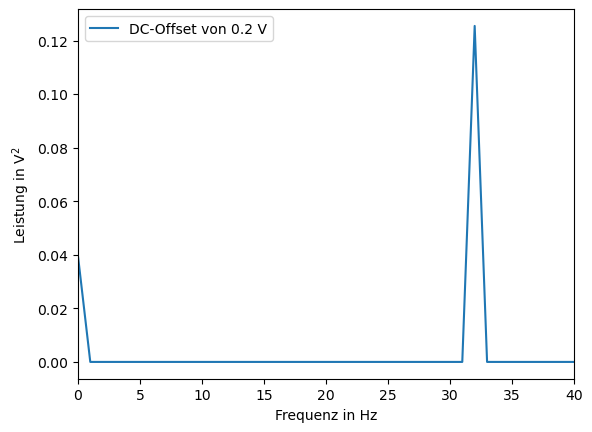

In [11]:
fig, ax =plt.subplots()

data = spektral('2/2c/off_0.2.aps','spec')
data.plot(ax,label='DC-Offset von 0.2 V')
plt.xlim(0,40)
plt.legend()

plt.savefig('figures/dc_anteil.pdf')

Unterabtastung\
Bei der Nyquist-Frequenz sieht man konstantes Spektrum von Null --> treffe stets gleichen Punkt\
750 Hz erscheint als f_abtast-750 Hz = 274 Hz

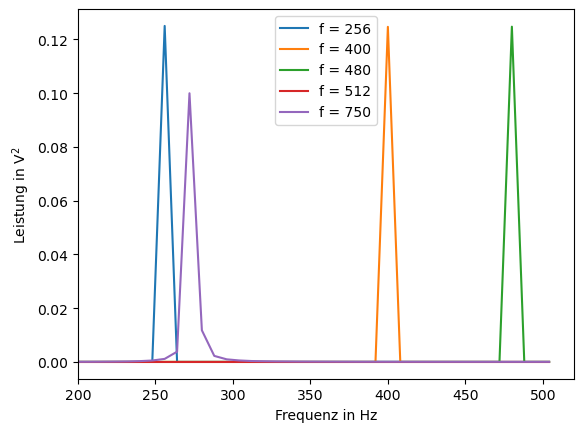

In [12]:
f = [256,400,480,512,750]

fig, ax = plt.subplots()

for i in f:
    data = spektral('2/2d/unter_'+str(i)+'.aps','spec')
    data.plot(ax,label='f = '+str(i))

plt.legend()
plt.xlim(200,520)
plt.savefig('figures/unterabtastung.pdf')

Überabtastung:

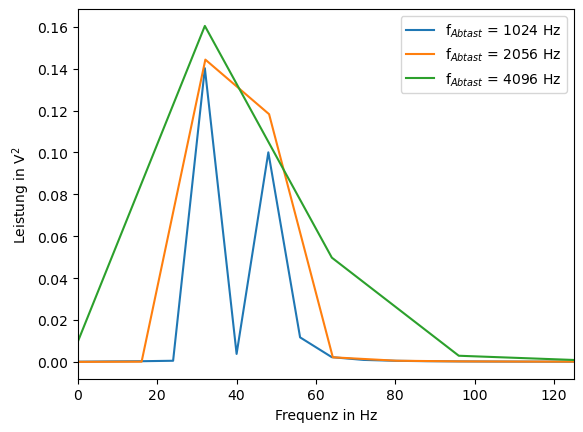

In [13]:
f_s = [1024,2056,4096]

fig, ax = plt.subplots()

for i in f_s:
    data = spektral('2/2d/ueber_'+str(i)+'.aps','spec')
    data.plot(ax,label=r'f$_{Abtast}$ = '+str(i)+' Hz')

plt.legend()
plt.xlim(0,125)
plt.savefig('figures/ueberabtastung.pdf')

Unterabtastung an Realdaten:

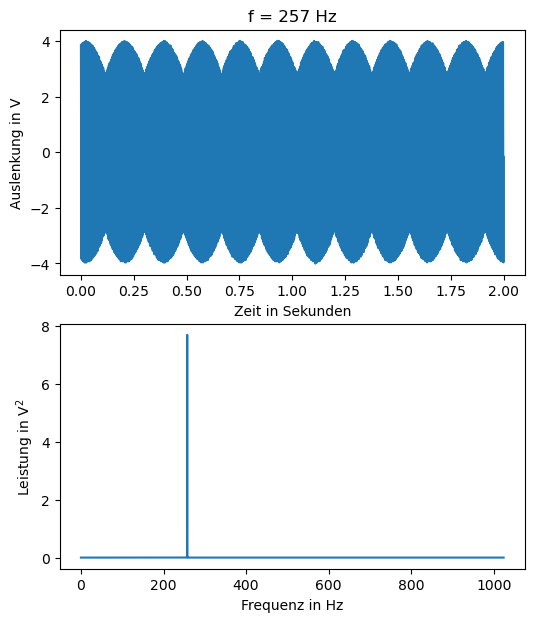

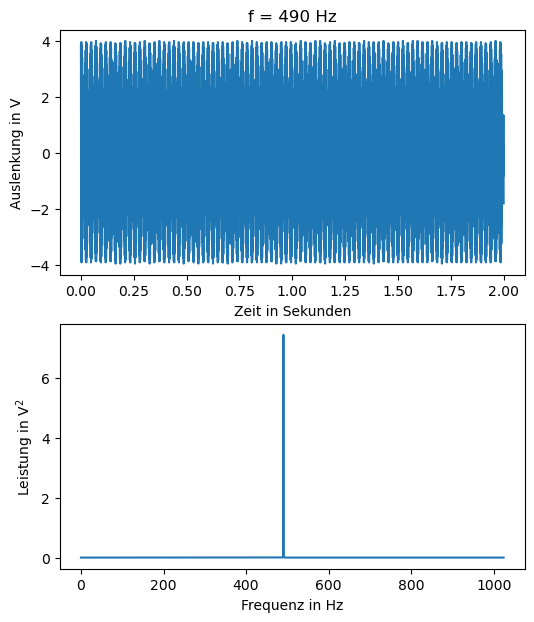

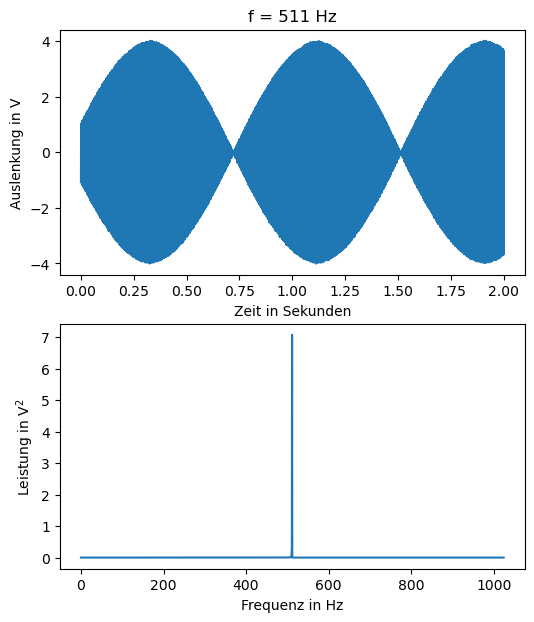

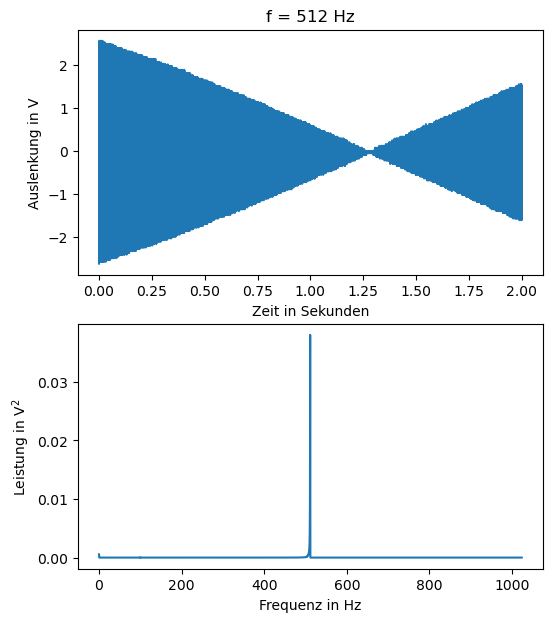

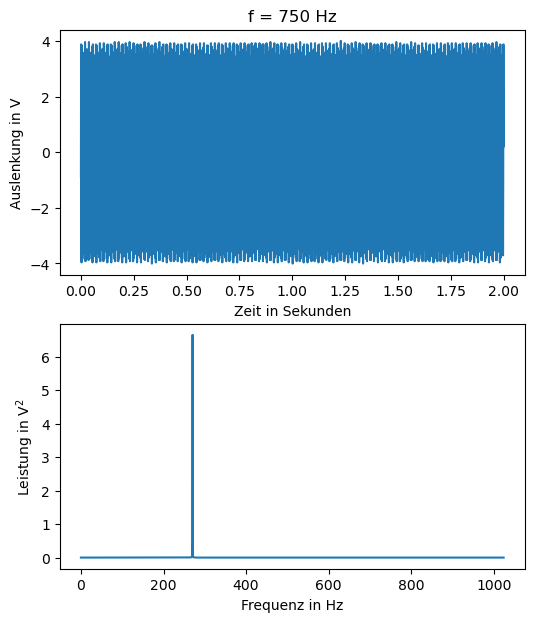

In [14]:
f = [257,490,511,512,750]

for i in f:
    data = spektral('extra/'+str(i)+'Hz.dat','time',f_A=1024.0)
    data.plot_both(title='f = '+str(i)+' Hz')
    plt.savefig('figures/unterabtastung_real_'+str(i)+'Hz.pdf')

Fensterfunktionen und Leackge. Zunächst die Überprüfung, ob die eigene Berechnung der dB-Spektren mit der Berechnung von Labview übereinstimmt.

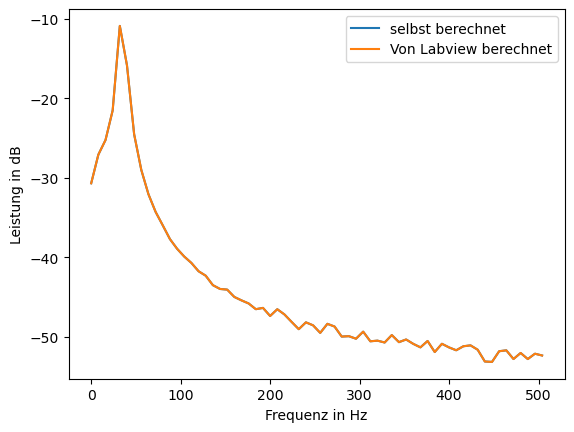

In [28]:
data3 = spektral('2/2f/leak_35.dat',time_or_spec='time',f_A=1024.0,dB=True,calc_dB=True)
data4 = spektral('2/2f/leak_35.aps',time_or_spec='spec',dB=True)

fig, ax = plt.subplots()

data3.plot(ax,label='selbst berechnet',which_plot='spec')
data4.plot(ax,label='Von Labview berechnet')

plt.legend()

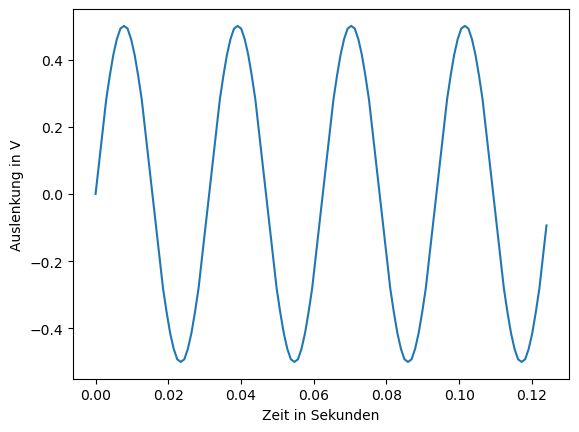

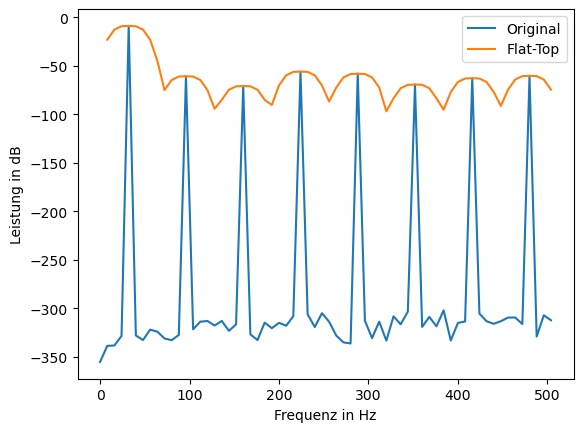

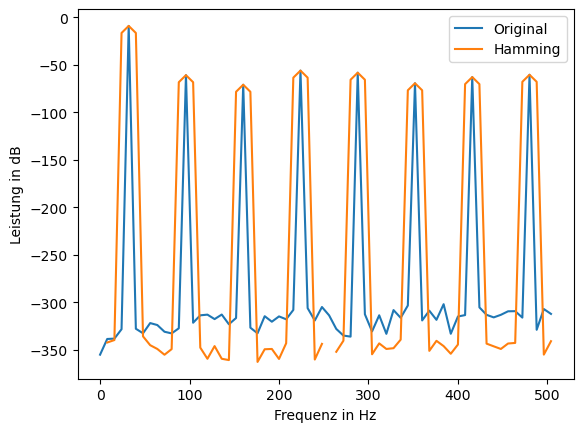

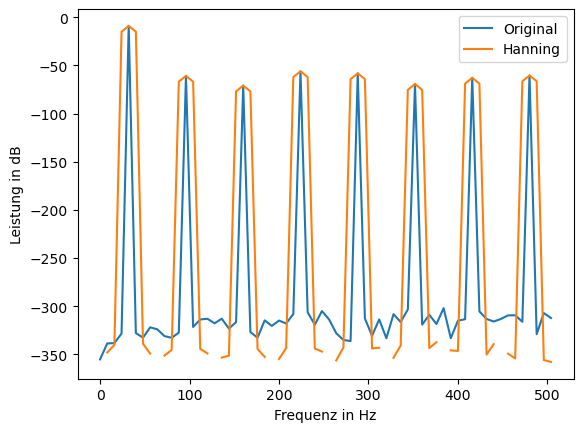

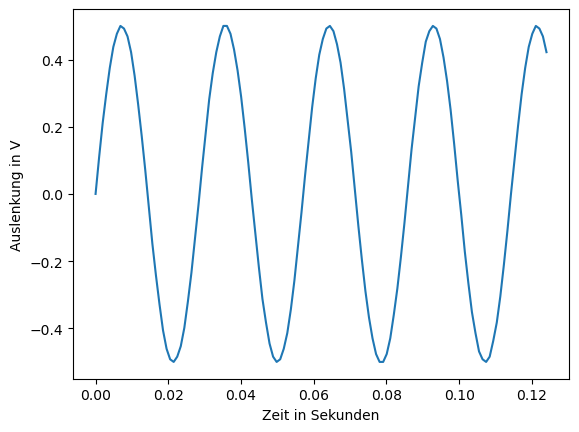

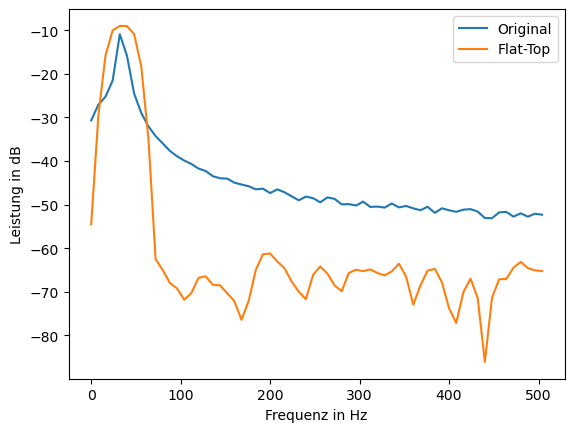

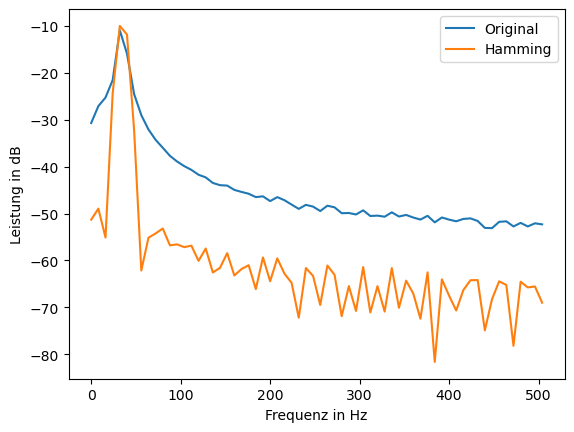

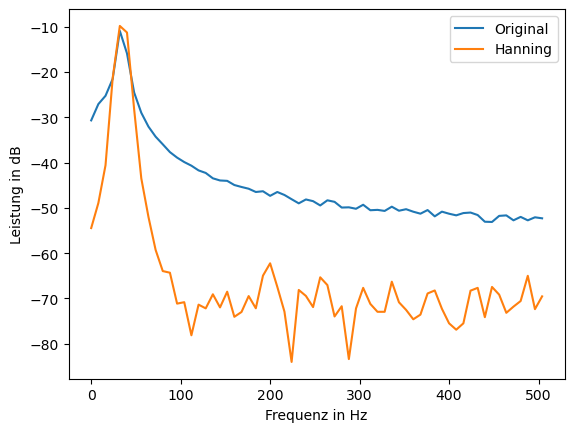

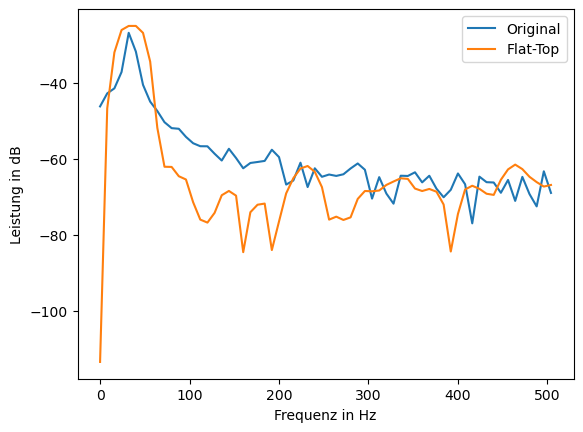

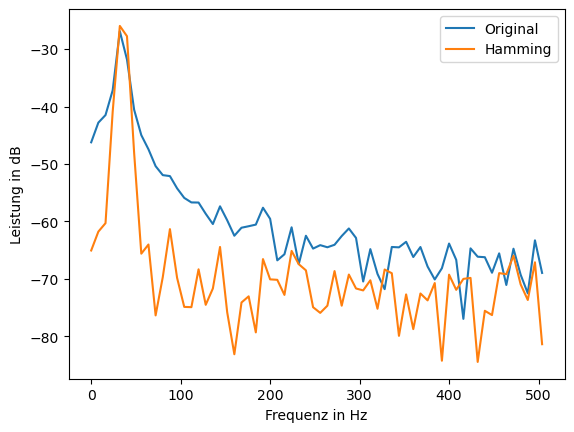

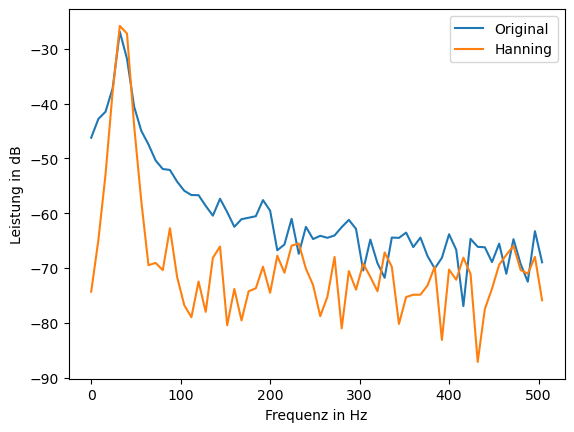

In [2]:
windows = ['flat','ham','han']
labels = ['Flat-Top','Hamming','Hanning']
# Hier noch savefig-Befehl

# 4 Perioden
data1 = spektral('2/2f/leak_32.dat',time_or_spec='time',f_A=1024.0,dB=True,calc_dB=True)
#data1 = spektral('2/2f/leak_32.aps',time_or_spec='spec',dB=True)
#signal = spektral('2/2f/leak_32.dat',time_or_spec='time')

fig, ax = plt.subplots()
#signal.plot(ax)
data1.plot(ax,which_plot='time')
plt.savefig('figures/leak_32_signal.pdf')

for i, label in zip(windows,labels):
    fig, ax = plt.subplots()
    data2 = spektral('2/2f/leak_32_'+str(i)+'.aps',time_or_spec='spec',dB=True)
    #data1.plot(ax,label='Original')
    #ax.scatter(data1.spec[0],data1.spec[1],marker='x')
    data1.plot(ax,label='Original',which_plot='spec')
    data2.plot(ax,label=label)
    plt.legend()
    plt.savefig('figures/leak_32_'+str(i)+'.pdf')
    
# ca. 4.5 Perioden
data1 = spektral('2/2f/leak_35.aps',time_or_spec='spec',dB=True)
signal = spektral('2/2f/leak_35.dat',time_or_spec='time')


fig, ax = plt.subplots()
signal.plot(ax)
plt.savefig('figures/leak_35_signal.pdf')

for i, label in zip(windows,labels):
    fig, ax = plt.subplots()
    data2 = spektral('2/2f/leak_35_'+str(i)+'.aps',time_or_spec='spec',dB=True)
    data1.plot(ax,label='Original')
    data2.plot(ax,label=label)
    plt.legend()
    plt.savefig('figures/leak_35_'+str(i)+'.pdf')


data1 = spektral('2/2f/leak_35_008.aps',time_or_spec='spec',dB=True)
# Hier haben wir keine .dat-Datei gespeichert. Das ist sehr ärgerlich.

for i, label in zip(windows,labels):
    fig, ax = plt.subplots()
    data2 = spektral('2/2f/leak_35_008_'+str(i)+'.aps',time_or_spec='spec',dB=True)
    data1.plot(ax,label='Original')
    data2.plot(ax,label=label)
    plt.legend()
    plt.savefig('figures/leak_35_008_'+str(i)+'.pdf')

Überschreitung des Eingangsspannungsbereiches des AD-Wandlers:\
dB-Spektren noch nicht zu sehen. Einheit so richtig??? Muss ich die Achsen umstellen???

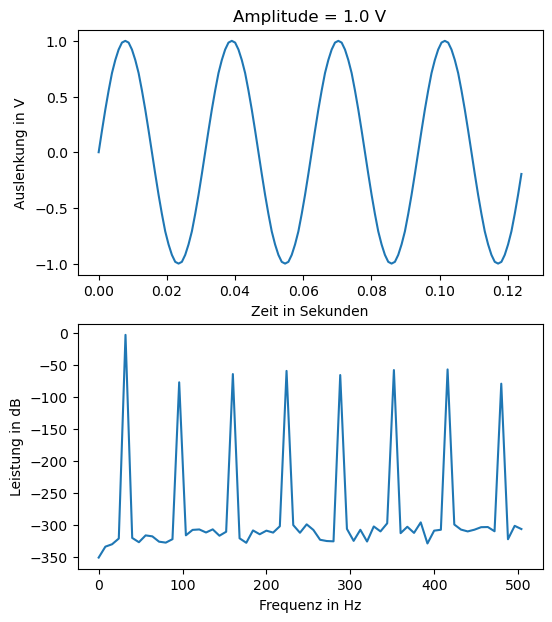

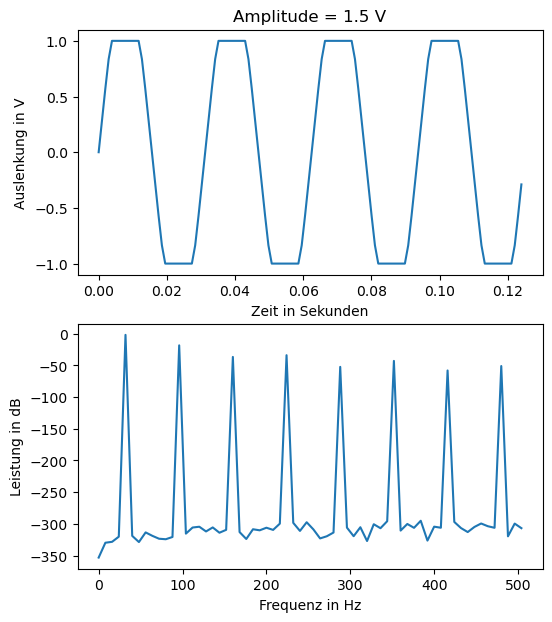

In [33]:
amp = [10,15]
label = ['1.0','1.5']

for i in range(len(amp)):
    data = spektral('2/2h/overload_'+str(amp[i])+'.dat',time_or_spec='time',f_A=1024.0,dB=True,calc_dB=True)
    # data = spektral('2/2h/overload_'+str(amp[i])+'.dat','time',f_A=1024.0)
    data.plot_both(title=r'Amplitude = '+label[i]+' V')
    plt.savefig('figures/eingangsspannung_ad'+str(amp[i])+'.pdf')

    # Scatter-Plot der dB-Spektren
    # fig, ax = plt.subplots()
    # ax.scatter(data.spec[0],data.spec[1],marker='x')


Offset an Realdaten:

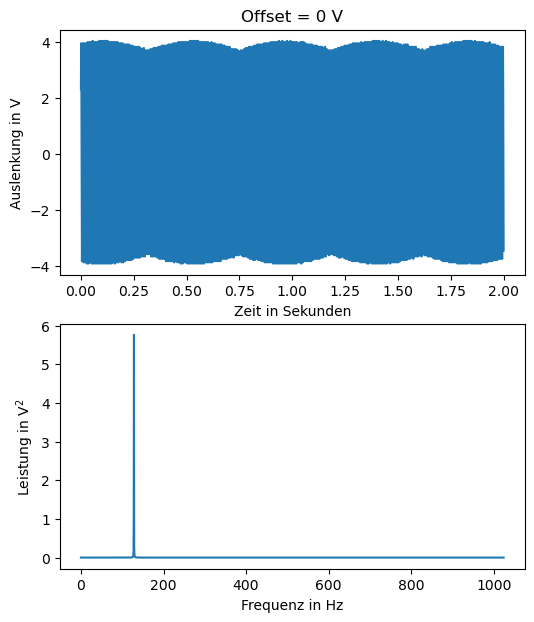

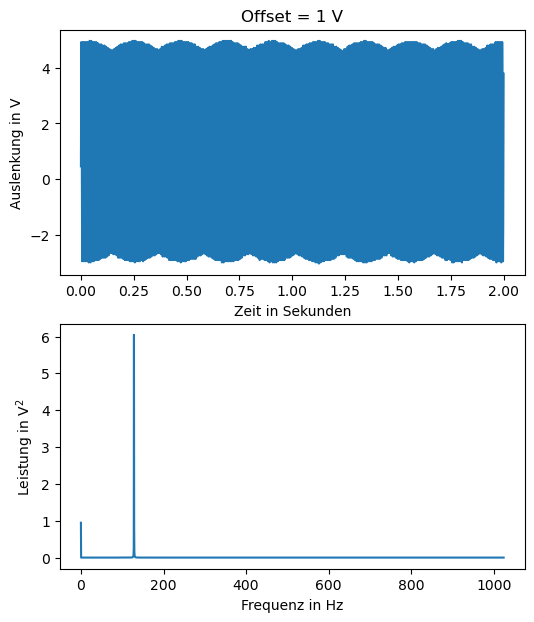

In [17]:
off = ['0DC','1VDC']

for i, val in enumerate(off):
    data = spektral('extra/8V_128Hz_'+val+'.dat','time',f_A=1024.0)
    data.plot_both(title='Offset = '+str(i)+' V')
    plt.savefig('figures/offset_real_'+val+'.pdf')

Quantisierungsrauschen:

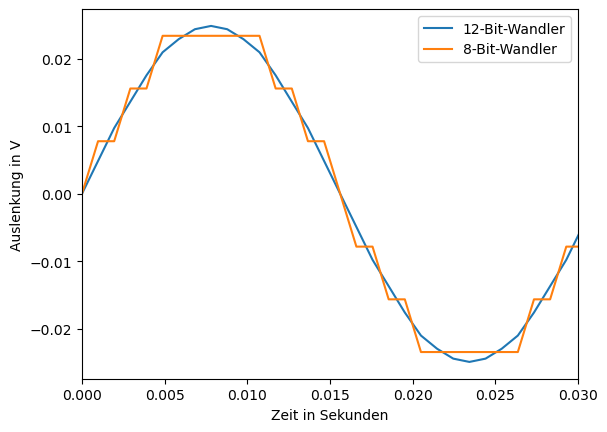

In [18]:
amp = [12,8]
fig, ax = plt.subplots()

for i in amp:
    data = spektral('2/2i/bit_'+str(i)+'.dat',time_or_spec='time')
    data.plot(ax,label=str(i)+'-Bit-Wandler')
plt.xlim(0,0.03)
plt.legend()
plt.savefig('figures/quantisierungsrauschen.pdf')

Quantisierungsrauschen an Realdaten:

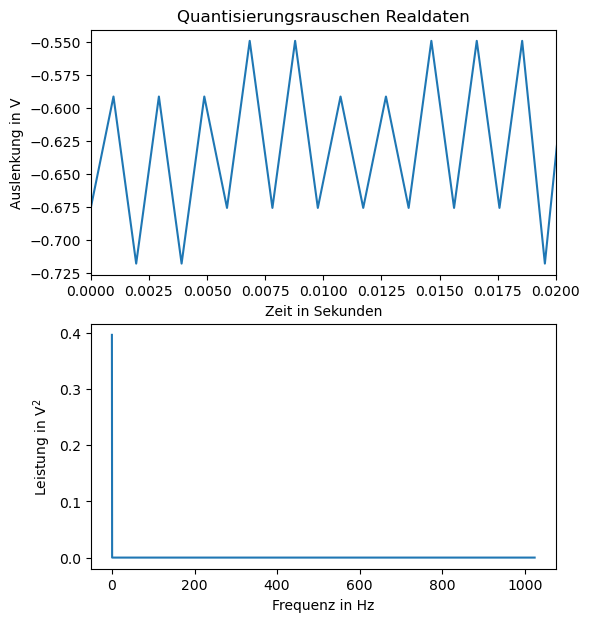

In [19]:
data = spektral('extra/144mV_quantisierung.dat','time',f_A=1024.0)
data.plot_both(title='Quantisierungsrauschen Realdaten',x1lim=(0.0,0.02))
plt.savefig('figures/quantisierungsrauschen_real.pdf')

Rechtecksignal Realdaten:

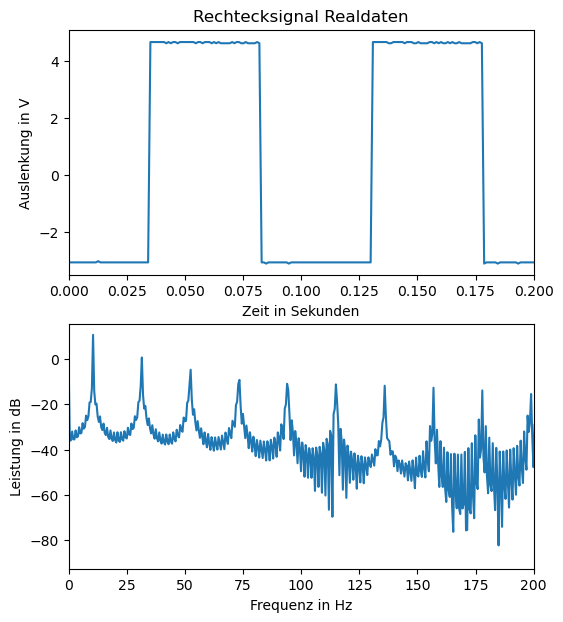

In [34]:
data = spektral('extra/rechteck.dat','time',f_A=1024.0,dB=True,calc_dB=True)
data.plot_both(title='Rechtecksignal Realdaten',x1lim=(0.0,0.2),x2lim=(0.0,200.0))
plt.savefig('figures/rechteck_real.pdf')